Why the Beam class need a modification

qv:


M_14*SingularityFunction(x, 14, -2) + R_14*SingularityFunction(x, 14, -1) + 6*SingularityFunction(x, 0, 0) + 16*SingularityFunction(x, 2, -1) + 1.0*SingularityFunction(x, 4, -1) - 1.2*SingularityFunction(x, 4, 0) - 4.8*SingularityFunction(x, 6.5, 0) - 32.0*SingularityFunction(x, 9, -1)

reaction loads:


{M_14: -435.000000000000, R_14: -21.0000000000000}

shear force:


-6*SingularityFunction(x, 0, 1) - 16*SingularityFunction(x, 2, 0) - 1.0*SingularityFunction(x, 4, 0) + 1.2*SingularityFunction(x, 4, 1) + 4.8*SingularityFunction(x, 6.5, 1) + 32.0*SingularityFunction(x, 9, 0) + 435.0*SingularityFunction(x, 14, -1) + 21.0*SingularityFunction(x, 14, 0)

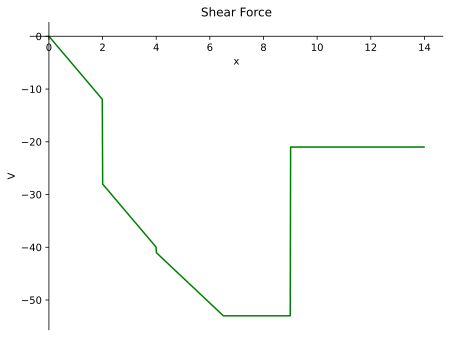

bending moment:


-3*SingularityFunction(x, 0, 2) - 16*SingularityFunction(x, 2, 1) - 1.0*SingularityFunction(x, 4, 1) + 0.6*SingularityFunction(x, 4, 2) + 2.4*SingularityFunction(x, 6.5, 2) + 32.0*SingularityFunction(x, 9, 1) + 435.0*SingularityFunction(x, 14, 0) + 21.0*SingularityFunction(x, 14, 1)

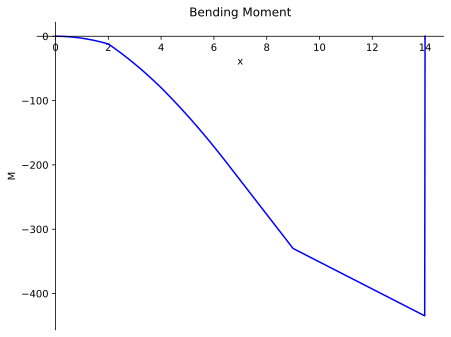

In [1]:
from sympy.physics.continuum_mechanics.beam import Beam
from sympy import symbols
import sympy as sp

%config InlineBackend.figure_format = 'svg'

# Material properties
E = 3e4
I = 1
b = Beam(14, E, I)

# Define symbols
Tr, Rv = symbols('Tr Rv')

# reaction loads at the fixed support (x=14)
Rv,Tr = b.apply_support(14, type='fixed')

# To THIS POINT there is no difference in workflow
##################### CUSTOM LOADS ############################################################################################################
# extra terms that need to be added to the load equation to handle bend points and vertical loads

x = sp.Symbol('x') # is the same as b.variable but easier to read required to hack in custom loads

# Define angles for bend points
theta_1 = sp.atan(3/4)  # Angle at x=4
theta_2 = sp.atan(-4/3)  # Angle at x=9

################## Add custom load equations to handle Fv and Fh
Fv = 16
Fh = 15

# in this case Fv is vertical so there is no issue with no defining angle
b.apply_load(Fv, 2, -1)

# below is the same as b.apply_load(Fv, 2, -1)
# load += Fv * sp.SingularityFunction(x, 2, -1)*sp.cos(0) + Fh * sp.SingularityFunction(x, 0, -1)* sp.sin(0)

################## Add custom load equations to handle qv angles
load_from_qv_angles = 0

# sthe load is not split and decomposed just start and end point with local angle (this is done to keep the bending moment correct??)
qv = 6
load_from_qv_angles += qv * sp.SingularityFunction(x, 0, 0) * sp.cos(0) - qv * sp.SingularityFunction(x, 6.5, 0) * sp.cos(theta_1)
qh = 0
#no need in this example for extra equations for qh=0

################## Add custom load equations to handle bend points
load_from_bend = 0

load_from_bend += (
    (Fv * sp.SingularityFunction(x, 4, -1)) * (sp.cos(theta_1) - sp.cos(0))
   +(Fv * sp.SingularityFunction(x, 9, -1)) * (sp.cos(theta_2) - sp.cos(theta_1))
    )

load_from_bend += (
    (Fh * sp.SingularityFunction(x, 4, -1)) * (sp.sin(theta_1) - sp.sin(0))
   +(Fh * sp.SingularityFunction(x, 9, -1)) * (sp.sin(theta_2) - sp.sin(theta_1))
    )

# this one i need some extra explanation on the -qv and how it works in general
load_from_bend += (
    (qv * ((sp.SingularityFunction(x, 4, 0) + (sp.SingularityFunction(x, 4, -1) * (4-0))) * (sp.cos(theta_1) - sp.cos(0))))
   +(qv * ((sp.SingularityFunction(x, 9, 0) + (sp.SingularityFunction(x, 9, -1) * (9-0))) * (sp.cos(theta_2) - sp.cos(theta_1))))
   #WAAROM -qv, om de kracht weer uit tezetten maar hoe precies ??? en waarom is het niet nodig om de sin termen(de x=4 plek) te doen?
   +(-qv * ((sp.SingularityFunction(x, 9, 0) + (sp.SingularityFunction(x, 9, -1) * (9-6.5))) * (sp.cos(theta_2) - sp.cos(theta_1))))
    )

#hack the extra term into the beam class
b._load += load_from_qv_angles + load_from_bend
###############################################################################################################################################
#normal workflow again

print('qv:')
display(b.load)

b.solve_for_reaction_loads(Tr, Rv)
print('reaction loads:')
display(b.reaction_loads)

ans = b.shear_force()
print('shear force:')
display(ans)
b.plot_shear_force()

ans2 = b.bending_moment()
print('bending moment:')
display(ans2)
b.plot_bending_moment()